## Introduction

In this project, we will analyze the spread of the new corona virus (nCov). We will use two datasets:
    - The John Hopkins University's dataset which contains aggregated daily data for confirmed cases, deaths and recovered patients. 
    https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
    - The DXY.cn's google sheet which contains information of about 1000 patients. 
    https://docs.google.com/spreadsheets/d/1jS24DjSPVWa4iuxuD4OAXrE3QeI8c9BC1hSlqr-NMiU/edit#gid=1187587451


Son Huynh
29.02.2020

About getting dataset:

The reddit's datasets group is a good place to look for datasets. For example, you can check out useful sources for nCov data from here: https://www.reddit.com/r/datasets/comments/exnzrd/coronavirus_datasets/

Reddit in general is great for getting tips and browsing discussions. Some of my favorite subreddits are dataisbeautiful, datascience, MachineLearning.


In [67]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
url_case = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_cured = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

Let's take a look at the case time series first

In [69]:
case = pd.read_csv(url_case, index_col=[0, 1, 2, 3])
cured = pd.read_csv(url_cured, index_col=[0, 1, 2, 3])
deaths = pd.read_csv(url_death, index_col=[0, 1, 2, 3])

case.head()


,,,,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20
Province/State,Country/Region,Lat,Long,,,,,,,,,,,,,,,,,,,,,
Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,106,152,200,237,...,990,990,990,990,990,990,990,990,990,990
Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,91,111,114,139,...,411,413,414,414,418,418,422,426,428,428
Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,132,147,182,211,...,576,576,576,576,576,576,576,576,576,576
Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,80,84,101,120,...,296,296,296,296,296,296,296,296,296,296
Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,19,24,26,29,...,91,91,91,91,91,102,119,120,124,124


Since the John Hopkins dataset contains only aggregated data, we need to transform it into a format that allows us to answer more questions. You can see the ideal dataframe structure in the picture below.

You will need to:
- Stack the dataframe so that each row represents one date in a location. 
- Remove the rows where the cumulative number of cases is zero.
- Make a new column `location` to combine `prov_state` and `country`.
- Make a new column `new_case` to derive the new case number from cumulative case number.
- Convert the date column to datetime object.

After transforming data for number of cases, you can do the same for number of deaths and cureds (or write a function to transform 3 datasets). Then you can use `pd.merge()` to merge them into one dataframe. Hint: try merging `case` with `death` first and then merge that with `cured`. You should use a `left` merge on `['location', 'prov_state', 'country', 'lat', 'long', 'date']` columns

![title](desired_format.png)

In [49]:
# stack to represent a location per row
stack = case.stack()
stack = stack.reset_index()

# rename columns
stack.columns = ['ProvinceState','CountryRegion', 'Lat', 'Long','date','cum_cases']

# remove rows where cummulative cases are 0
stack = stack[stack.cum_cases!=0]

# create a location column combining ProviceState or CountryRegion
stack['location'] = np.where(stack.ProvinceState.notna(), stack.ProvinceState, stack.CountryRegion)

# create a new cases column
# stack['new_cases'] = np.where(stack.cum_cases.diff(periods=1)>=0, stack.cum_cases.diff(periods=1), stack.cum_cases)
stack['new_cases'] = stack.groupby('location').cum_cases.diff(1)
stack.new_cases = stack.new_cases.fillna(stack.cum_cases)

# convert the date column to datetime object
stack.date = pd.to_datetime(stack.date, format='%m/%d/%y', errors='coerce')

# rearranging the columns and assigning to dataframe variable.
df = stack[['location', 'ProvinceState', 'CountryRegion', 'Lat', 'Long', 'date', 'cum_cases', 'new_cases']]

df.iloc[1505:1550]

,location,ProvinceState,CountryRegion,Lat,Long,date,cum_cases,new_cases
1523,Thailand,NaN,Thailand,15.0,101.0,2020-02-26,40,3.0
1524,Thailand,NaN,Thailand,15.0,101.0,2020-02-27,40,0.0
1525,Thailand,NaN,Thailand,15.0,101.0,2020-02-28,41,1.0
1526,Thailand,NaN,Thailand,15.0,101.0,2020-02-29,42,1.0
1527,Thailand,NaN,Thailand,15.0,101.0,2020-03-01,42,0.0
1528,Thailand,NaN,Thailand,15.0,101.0,2020-03-02,43,1.0
1529,Thailand,NaN,Thailand,15.0,101.0,2020-03-03,43,0.0
1530,Thailand,NaN,Thailand,15.0,101.0,2020-03-04,43,0.0
1531,Thailand,NaN,Thailand,15.0,101.0,2020-03-05,47,4.0
1532,Thailand,NaN,Thailand,15.0,101.0,2020-03-06,48,1.0


In [50]:
# data for cured and deaths are arranged in the same manner as cases
cured.head()

,,,,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20
Province/State,Country/Region,Lat,Long,,,,,,,,,,,,,,,,,,,,,
Anhui,Mainland China,31.8257,117.2264,0,0,0,0,0,0,0,2,2,3,...,868,873,917,936,956,970,979,979,984,984
Beijing,Mainland China,40.1824,116.4142,0,0,1,2,2,2,4,4,4,5,...,271,276,282,288,297,297,299,303,308,315
Chongqing,Mainland China,30.0572,107.8740,0,0,0,0,0,0,0,1,1,1,...,438,450,469,490,502,512,513,526,527,542
Fujian,Mainland China,26.0789,117.9874,0,0,0,0,0,0,0,0,0,0,...,243,247,255,260,270,277,284,295,295,295
Gansu,Mainland China,36.0611,103.8343,0,0,0,0,0,0,0,0,0,0,...,82,84,85,86,87,87,87,87,87,88


In [51]:
stack = deaths.stack()
stack = stack.reset_index()

# rename columns
stack.columns = ['ProvinceState','CountryRegion', 'Lat', 'Long','date','cum_deaths']
# stack = stack[stack.cum_deaths>0]

# create a location column combining ProviceState or CountryRegion
stack['location'] = np.where(stack.ProvinceState.notna(), stack.ProvinceState, stack.CountryRegion)

# create a new deaths column
# stack['new_deaths'] = np.where(stack.cum_deaths.diff(periods=1)>=0, stack.cum_deaths.diff(periods=1), stack.cum_deaths)
stack['new_deaths'] = stack.groupby('location').cum_deaths.diff(1)
stack.new_deaths = stack.new_deaths.fillna(stack.cum_deaths)

# convert the date column to datetime object
stack.date = pd.to_datetime(stack.date, format='%m/%d/%y', errors='coerce')

# rearrange dataframe.
stack = stack[['location', 'ProvinceState', 'CountryRegion', 'Lat', 'Long', 'date', 'cum_deaths', 'new_deaths']]

# merge deaths with cases
df = df.merge(stack)
df.head(20)
df[df.new_deaths<0]

,location,ProvinceState,CountryRegion,Lat,Long,date,cum_cases,new_cases,cum_deaths,new_deaths


In [75]:
stack = cured.stack()
stack = stack.reset_index()

# rename columns
stack.columns = ['ProvinceState','CountryRegion', 'Lat', 'Long','date','cum_cured']

# create a location column combining ProviceState or CountryRegion
stack['location'] = np.where(stack.ProvinceState.notna(), stack.ProvinceState, stack.CountryRegion)

# create a new cases column
# stack['new_cured'] = np.where(stack.cum_cured.diff(periods=1)>=0, stack.cum_cured.diff(periods=1), stack.cum_cured)
stack['new_cured'] = stack.groupby('location').cum_cured.diff(1)
stack.new_cured = stack.new_cured.fillna(stack.cum_cured)

# convert the date column to datetime object
stack.date = pd.to_datetime(stack.date, format='%m/%d/%y', errors='coerce')

# rearrange dataframe.
stack = stack[['location', 'ProvinceState', 'CountryRegion', 'Lat', 'Long', 'date', 'cum_cured', 'new_cured']]

# merge cured with cases
df = df.merge(stack)


In [129]:
df.groupby(df.location=='US')['cum_cases']

AttributeError: Cannot access callable attribute 'tolist' of 'SeriesGroupBy' objects, try using the 'apply' method

,,,,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20
Province/State,Country/Region,Lat,Long,,,,,,,,,,,,,,,,,,,,,
Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,106,152,200,237,...,990,990,990,990,990,990,990,990,990,990
Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,91,111,114,139,...,411,413,414,414,418,418,422,426,428,428
Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,132,147,182,211,...,576,576,576,576,576,576,576,576,576,576
Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,80,84,101,120,...,296,296,296,296,296,296,296,296,296,296
Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,19,24,26,29,...,91,91,91,91,91,102,119,120,124,124


In [81]:
df.head()

,location,ProvinceState,CountryRegion,Lat,Long,date,cum_cases,new_cases,cum_deaths,new_deaths,cum_cured,new_cured
0,Anhui,Anhui,Mainland China,31.8257,117.2264,2020-01-22,1,1.0,0,0.0,0,0.0
1,Anhui,Anhui,Mainland China,31.8257,117.2264,2020-01-23,9,8.0,0,0.0,0,0.0
2,Anhui,Anhui,Mainland China,31.8257,117.2264,2020-01-24,15,6.0,0,0.0,0,0.0
3,Anhui,Anhui,Mainland China,31.8257,117.2264,2020-01-25,39,24.0,0,0.0,0,0.0
4,Anhui,Anhui,Mainland China,31.8257,117.2264,2020-01-26,60,21.0,0,0.0,0,0.0


In [113]:
df.CountryRegion.unique()

array(['Mainland China', 'Thailand', 'Japan', 'South Korea', 'Taiwan',
       'US', 'Macau', 'Hong Kong', 'Singapore', 'Vietnam', 'France',
       'Nepal', 'Malaysia', 'Canada', 'Australia', 'Cambodia',
       'Sri Lanka', 'Germany', 'Finland', 'United Arab Emirates',
       'Philippines', 'India', 'Italy', 'UK', 'Russia', 'Sweden', 'Spain',
       'Belgium', 'Others', 'Egypt', 'Iran', 'Lebanon', 'Iraq', 'Oman',
       'Afghanistan', 'Bahrain', 'Kuwait', 'Algeria', 'Croatia',
       'Switzerland', 'Austria', 'Israel', 'Pakistan', 'Brazil',
       'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania',
       'Denmark', 'Estonia', 'Netherlands', 'San Marino', 'Belarus',
       'Iceland', 'Lithuania', 'Mexico', 'New Zealand', 'Nigeria',
       'Ireland', 'Luxembourg', 'Monaco', 'Qatar', 'Ecuador',
       'Azerbaijan', 'Czech Republic', 'Armenia', 'Dominican Republic',
       'Indonesia', 'Portugal', 'Andorra', 'Latvia', 'Morocco',
       'Saudi Arabia', 'Senegal', 'Argentina', 'Chil

In [114]:
countries_benelux = ['Belgium', 'Netherlands', 'Luxembourg']
countries_northEU = ['Denmark','Iceland', 'Finland', 'Norway', 'Sweden']
countries_southEU = ['Greece', 'Italy', 'Malta', 'Portugal', 'Spain']
countries_northAmerica = ['US', 'Canada', 'Mexico']

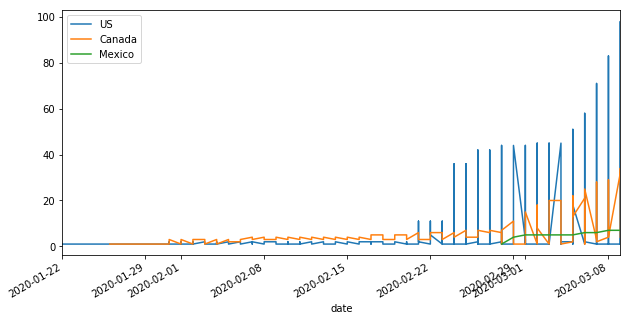

In [118]:
# north europe
fig, ax = plt.subplots(1, 1, figsize = (10,5))
for country in countries_northAmerica:
    df[df.CountryRegion == country].plot(y='cum_cases', x='date', kind='line', ax=ax, label=country)


In [121]:
df[df.CountryRegion == 'US'].cum_cases.iloc[100:150]

2129     1
2130     1
2131     1
2132     1
2133     1
2134     1
2135     1
2136     1
2137     1
2138     1
2139     1
2140     1
2141     1
2142     1
2143     1
2144     1
2145     1
2146     1
2147     1
2148     1
2149     1
2150     1
2151     1
2152     1
2153     1
2154     1
2155     1
2156     1
2157     1
2158     1
2159     1
2160     1
2161     7
2162    11
2163    13
2164    14
2165    14
2166    14
2819     2
2820     2
2821     2
2822     2
2823     2
2824     2
2825     2
2826     2
2827     2
2828     2
2829     2
2830     2
Name: cum_cases, dtype: int64